# Credit card default propensity prediction

__Objective__ – Predict the probability of a customer defaulting payment for the credit card the subsequent month, based on past information. The past information is provided in the dataset. This probability will help the collections team to prioritise follow up with customers who have a high propensity of defaulting.

## Project instructions
1.	Perform the required data pre-processing to treat for missing values and outliers
2.	Perform exploratory data analysis to visualise the spread of each of the X variables and the relationship between the various X variables and the Y variable
3.	Identify any multi-collinearity and perform dimensionality reduction like PCA if required
4.	Use the original X variables or the components from PCA & divide the given data into train and test sets
5.	Build a model to predict the default propensity of a customer
6.	Evaluate the model based on model performance measures for classification and recommend the most suitable model.
7.	Come up with recommendations / actionable insights based on feature importance scores derived from the model.


## About the dataset
The dataset contains the following information of 30000 customers:
1.	__DEFAULT__ - Default payment next month (Yes=1, No=0)
2.	__LIMIT_BAL__ - Amount of the given credit (INR)  
3.	__SEX__ - Gender (1 = male; 2 = female)
4.	__EDUCATION__ - Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
5.	__MARRIAGE__ - (1 = married; 2 = single; 3 = others)
6.	__AGE__ - (year)
7.	__PAST_PAY__ - History of repayment status
    <br> -  PAST_PAY1 = the repayment status in September 2005
    <br> -  PAST_PAY2 = the repayment status in August 2005
    <br> -  PAST_PAY6 = the repayment status in April 2005
    <br> -  The measurement scale for the repayment status is 
         i.  -1 = pay duly <br>
        ii.	 1 = payment delay for one month<br>
        iii. 2 = payment delay for two months <br>
        iv.	 8 = payment delay for eight months<br>
        v.	 9 = payment delay for nine months and above <br>
8.	__BILL_AMT__- Amount of bill statement (INR)
    <br> -  BILL_AMT1 = amount of bill statement in September 2005
    <br> -  BILL_AMT2 = amount of bill statement in August 2005
    <br> -  BILL_AMT6 = amount of bill statement in April 2005
9.	__PAY_AMT__ - Amount of previous payment (INR)
    <br> -  PAY_AMT1 = amount paid in September 2005
    <br> -  PAY_AMT2 = amount paid in August 2005
    <br> -  PAY_AMT6 = amount paid in April 2005


## Additional information
1.	The difference between the bill amount and the past pay for a month will give an indication of the pending amount for each month and can be used as an additional X variable
2.	The average / sum of bill amount can be used as an additional X variable which will give an indication on the customer value.


In [1]:
# Importing important libraries

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import statsmodels.api   as sm

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection   import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model      import LogisticRegression
from sklearn.metrics           import classification_report
from sklearn.tree              import DecisionTreeClassifier
from sklearn.ensemble          import RandomForestClassifier
from scipy.stats               import randint as sp_randint
from imblearn.over_sampling    import SMOTE

In [2]:
# Read the dataset and display first five rows

df = pd.read_csv('credit_card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
print("There are {} rows and {} columns in the dataset.".format(df.shape[0],df.shape[1]))

There are 30000 rows and 25 columns in the dataset.


In [4]:
# To see the datatypes of the column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

## Descriptive Statistics:

In [5]:
# Five point summary of the dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


Inference:
    - There are around 30000 distict credit card clients.
    - The average value of credit card Limits is Rs 1,67,484.
    - The Limited Balance has a high Standard deviation as the meadian value is Rs 1,40,000 and the extreme values as Rs 10,00,000.
    - Here the average is about 35 and meadian is 28 with a standard deviation of 9.2. This difference is explained by some very old people in the data set as given that the maximum age is 79.
    - Bill Amount and Pay Amount also shows us that there some people with extremely high bill amount which may be because for the higher Credit Limit or because of the pending dues added up. 
    - Bill amount for all the months, the mean is around 40,000 to 50,000 with some extreme amount in bill amount 3 of Rs 16,64,089.
    - Pay amount for all the months, the mean is around Rs 4800 to Rs 5800, with some extreme values such as Rs 16,64,089.
    - As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis).

In [6]:
print("There are {} missing records in the dataset.".format(df.isnull().sum().sum()))

There are 0 missing records in the dataset.


In [7]:
# Storing feature names in variable 'cols'

cols = df.columns.tolist()

## Exploratory Data Analysis:

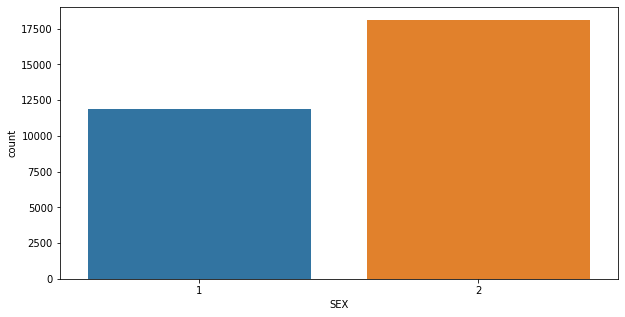

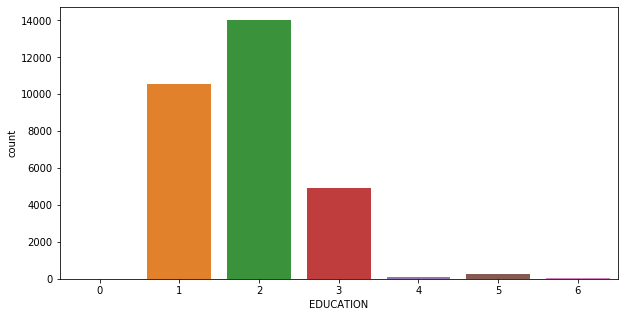

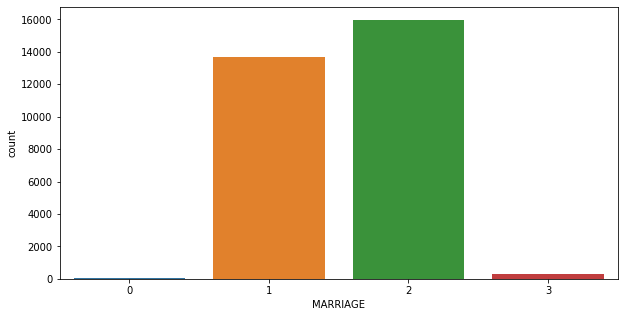

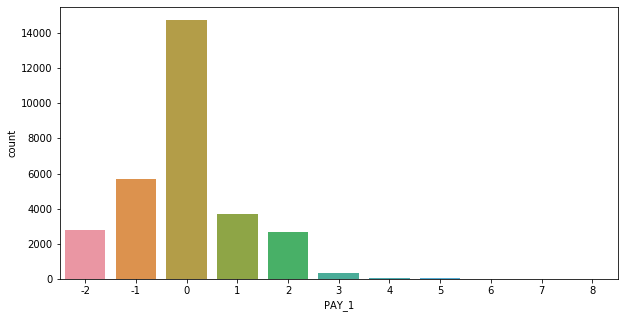

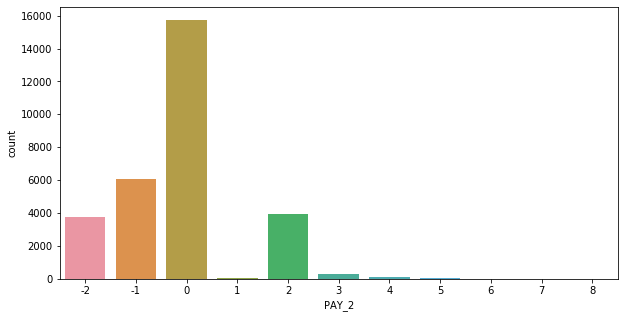

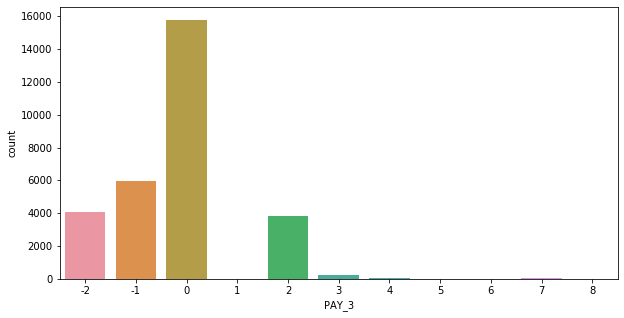

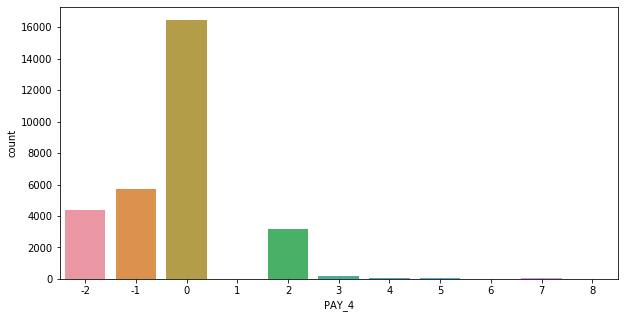

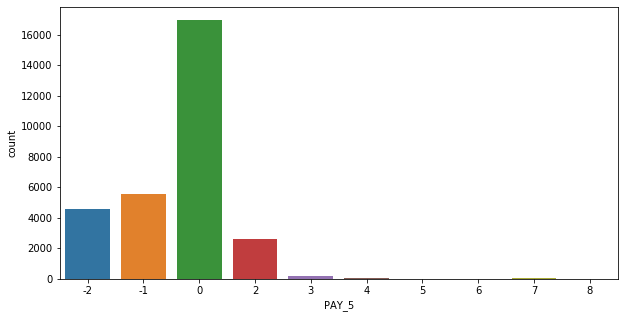

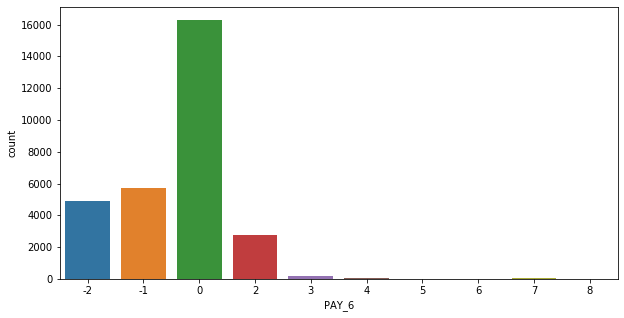

In [8]:
for i in [ 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    plt.figure(figsize=(10,5))
    sns.countplot(df[i])
    plt.show()

#### BOX PLOT - Outliers:

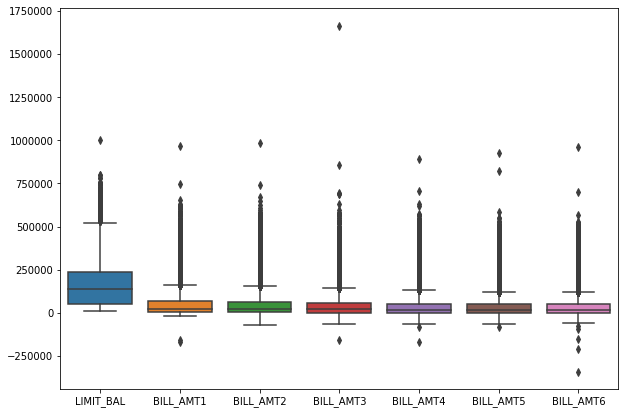

In [9]:
# Boxplot for Bill_Amt vs Limit_bal

plt.figure(figsize=(10,7))
sns.boxplot(data=df[['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']])
plt.show()

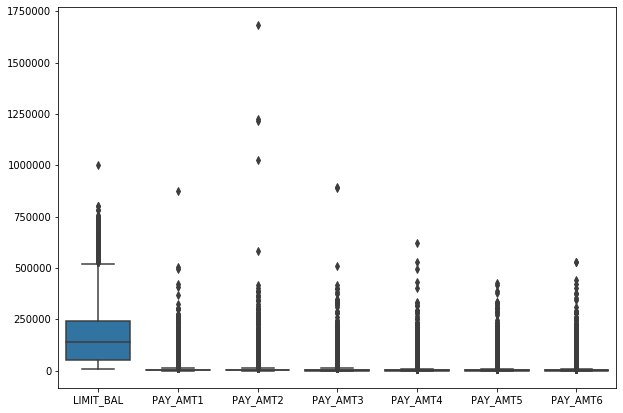

In [10]:
# Boxplot for Pay_Amt vs Limit_bal

plt.figure(figsize=(10,7))
sns.boxplot(data=df[['LIMIT_BAL','PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']])
plt.show()

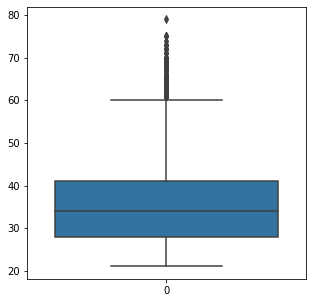

In [11]:
# Boxplot for column 'AGE'
plt.figure(figsize=(5,5))
sns.boxplot(data=df['AGE'])
plt.show()

#### Outliers:

In [12]:
# Outliers on numberical columns

num_var = df.select_dtypes(exclude='object')
for i in num_var:
    
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)

    IQR = q3 - q1
    UL = q3 + 1.5*IQR
    LL = q1 - 1.5*IQR

    print('IQR of',i,'= ',IQR)
    print('UL of',i,'= ',UL)
    print('LL of',i,'= ',LL)
    print('Number of Outliers in',i,' = ',(df.shape[0] - df[(df[i]<UL) & (df[i]>LL)].shape[0]))
    print(' ')

IQR of ID =  14999.5
UL of ID =  44999.5
LL of ID =  -14998.5
Number of Outliers in ID  =  0
 
IQR of LIMIT_BAL =  190000.0
UL of LIMIT_BAL =  525000.0
LL of LIMIT_BAL =  -235000.0
Number of Outliers in LIMIT_BAL  =  167
 
IQR of SEX =  1.0
UL of SEX =  3.5
LL of SEX =  -0.5
Number of Outliers in SEX  =  0
 
IQR of EDUCATION =  1.0
UL of EDUCATION =  3.5
LL of EDUCATION =  -0.5
Number of Outliers in EDUCATION  =  454
 
IQR of MARRIAGE =  1.0
UL of MARRIAGE =  3.5
LL of MARRIAGE =  -0.5
Number of Outliers in MARRIAGE  =  0
 
IQR of AGE =  13.0
UL of AGE =  60.5
LL of AGE =  8.5
Number of Outliers in AGE  =  272
 
IQR of PAY_1 =  1.0
UL of PAY_1 =  1.5
LL of PAY_1 =  -2.5
Number of Outliers in PAY_1  =  3130
 
IQR of PAY_2 =  1.0
UL of PAY_2 =  1.5
LL of PAY_2 =  -2.5
Number of Outliers in PAY_2  =  4410
 
IQR of PAY_3 =  1.0
UL of PAY_3 =  1.5
LL of PAY_3 =  -2.5
Number of Outliers in PAY_3  =  4209
 
IQR of PAY_4 =  1.0
UL of PAY_4 =  1.5
LL of PAY_4 =  -2.5
Number of Outliers in PAY_4

#### Distribution Plot:

In [13]:
mi0 = df[df['DEFAULT']==0]
mi1 = df[df['DEFAULT']==1]

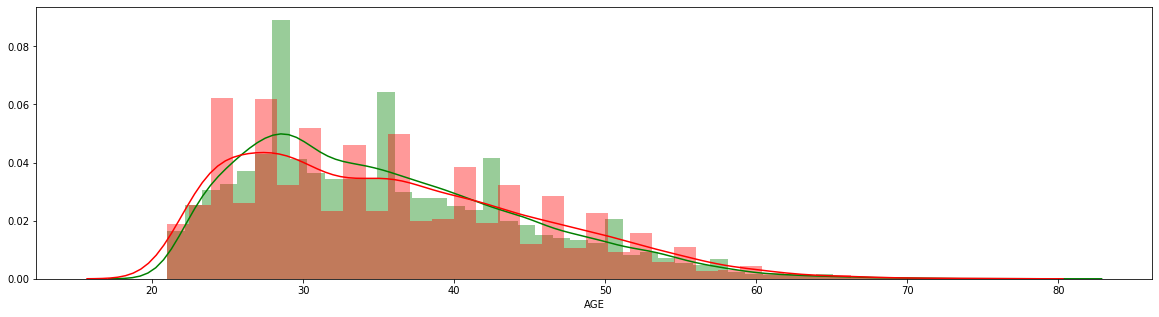

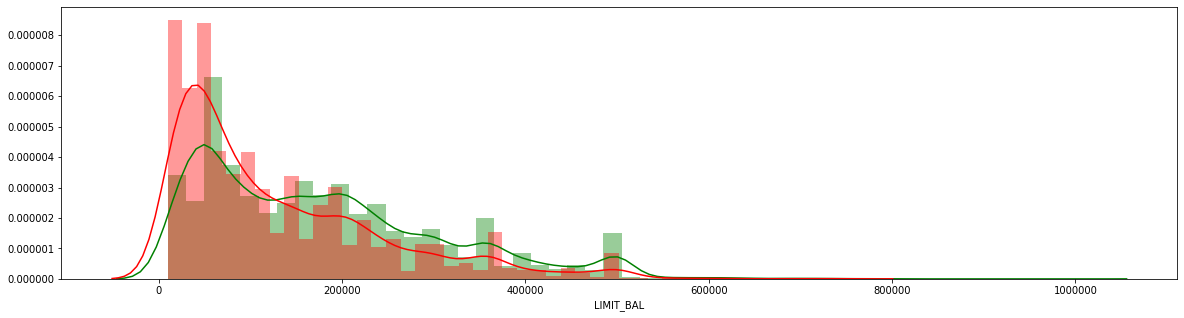

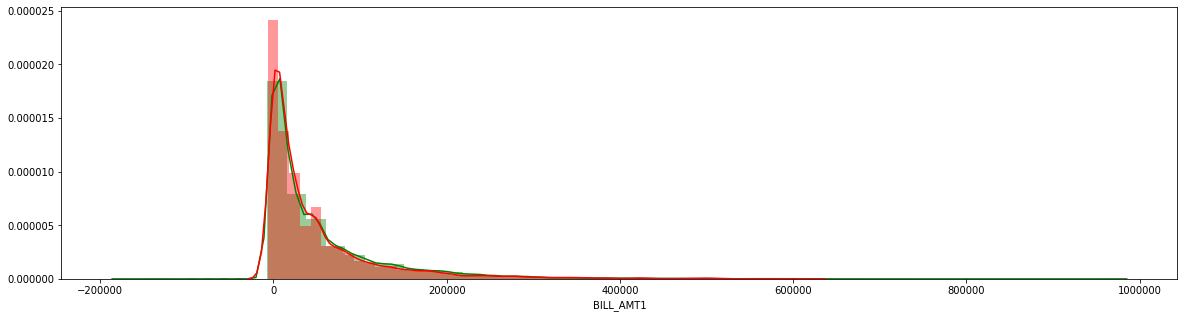

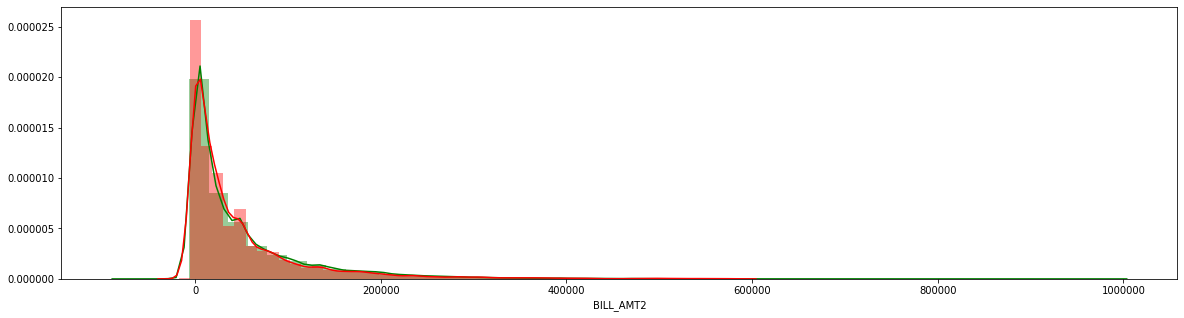

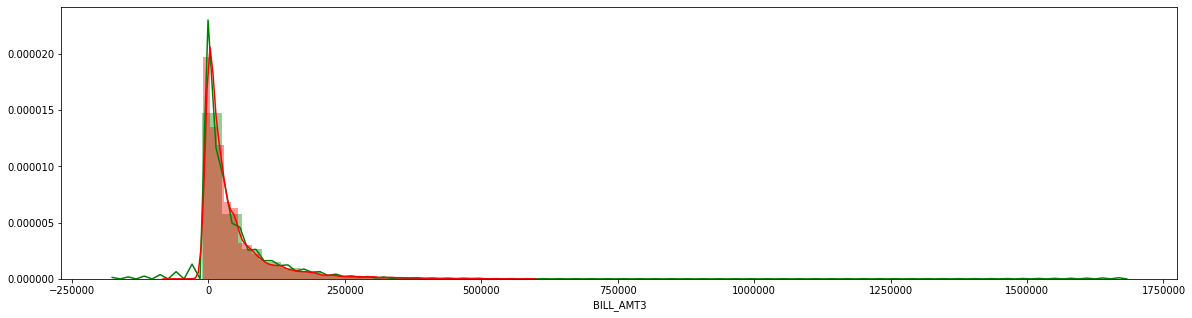

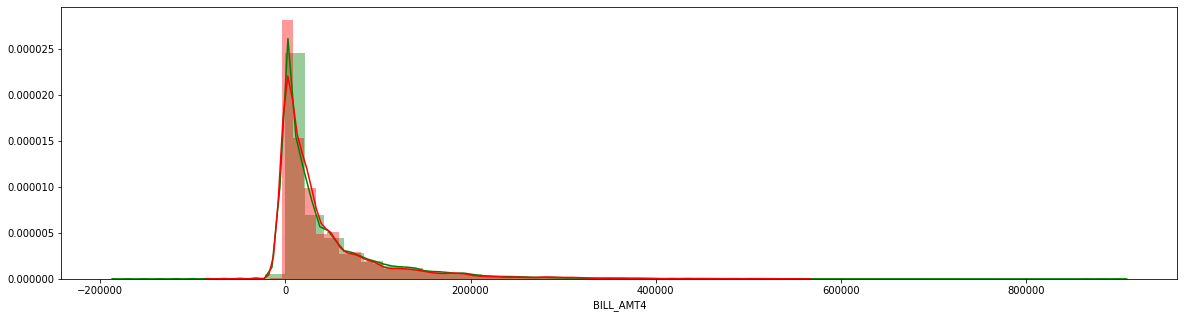

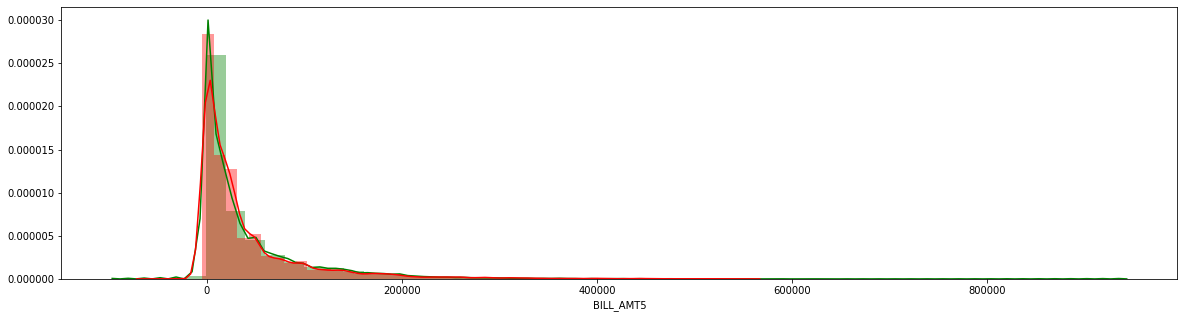

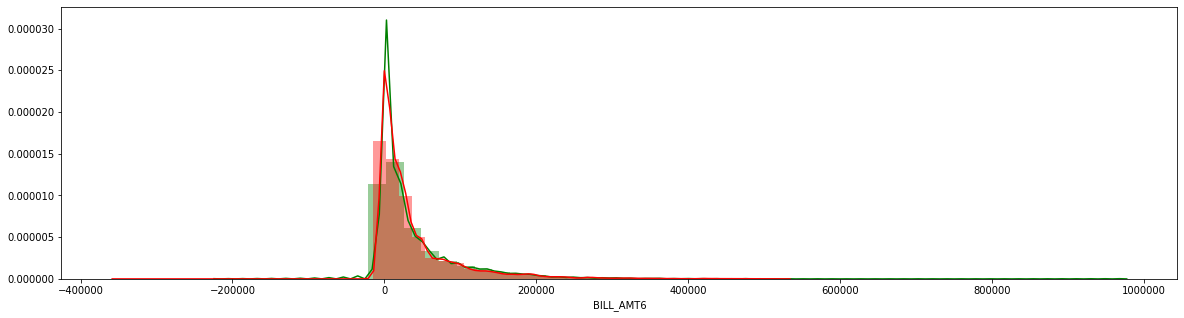

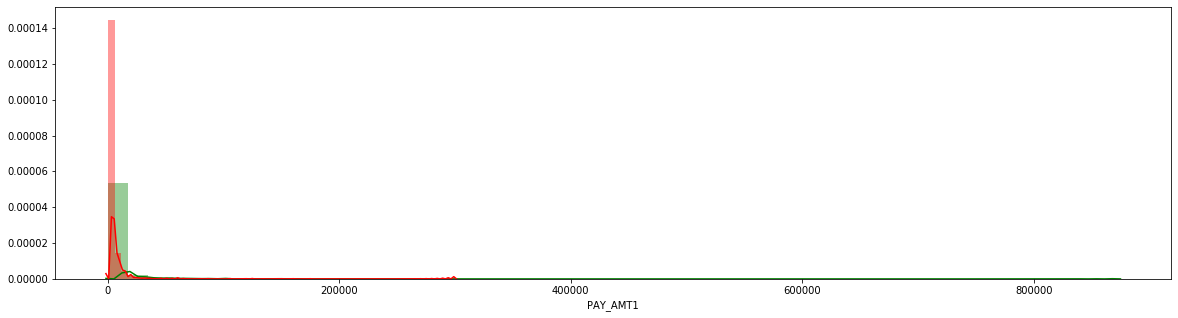

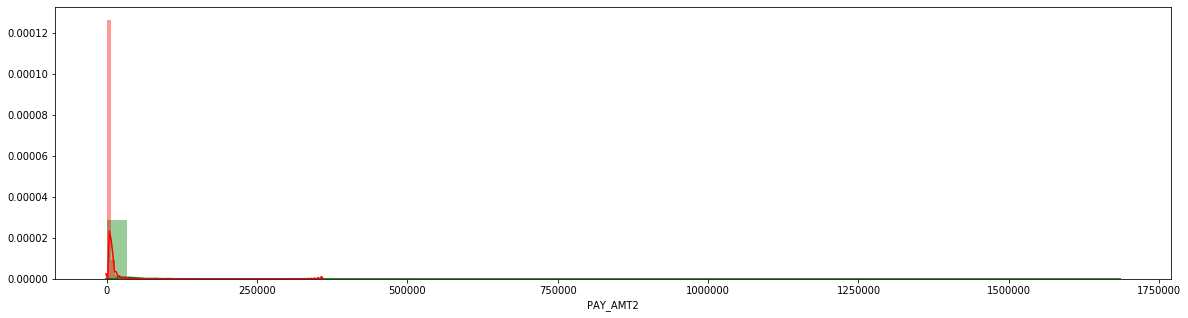

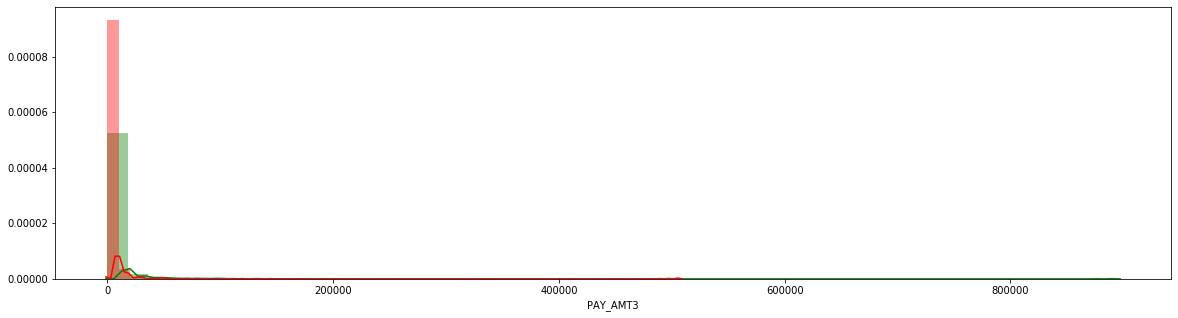

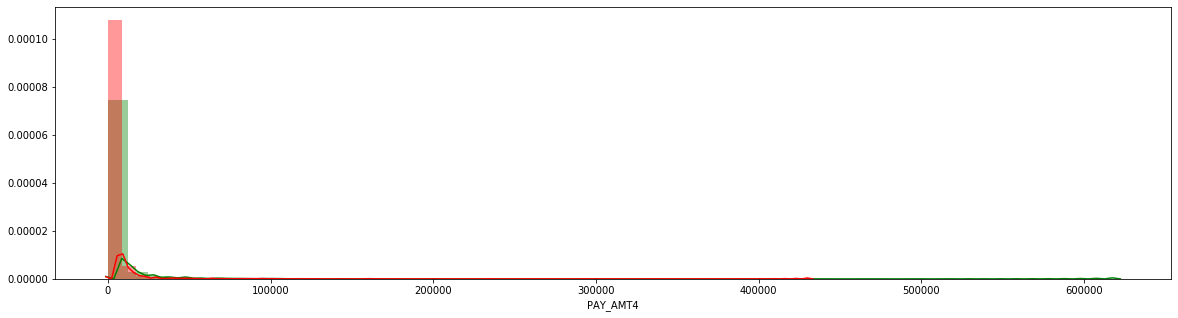

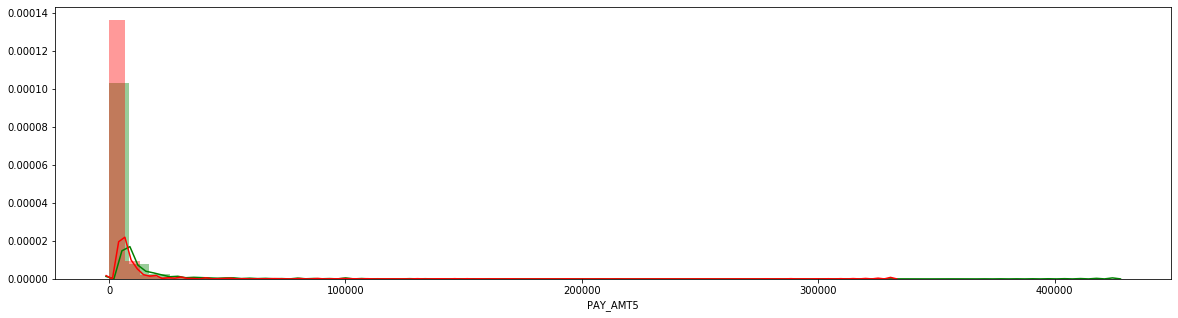

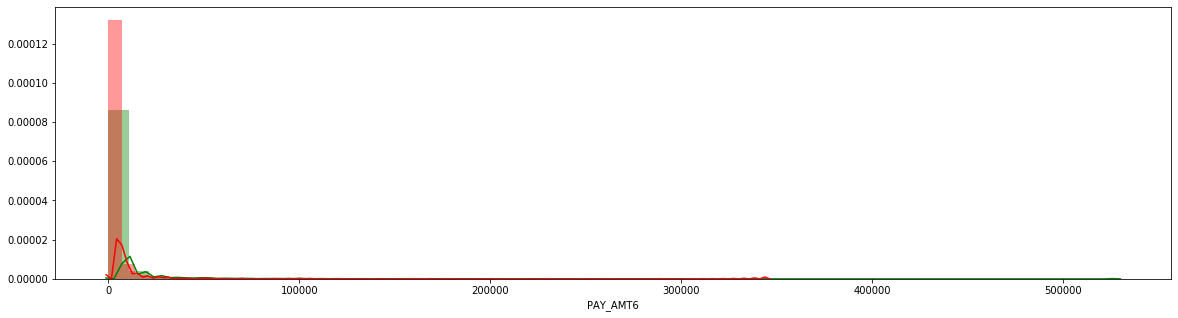

In [14]:
con_col=['AGE','LIMIT_BAL','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for i in con_col:
    plt.figure(figsize=(20,5))
    sns.distplot(mi0[i],color='g')
    sns.distplot(mi1[i],color='r')
    plt.show()

#### Heat map:

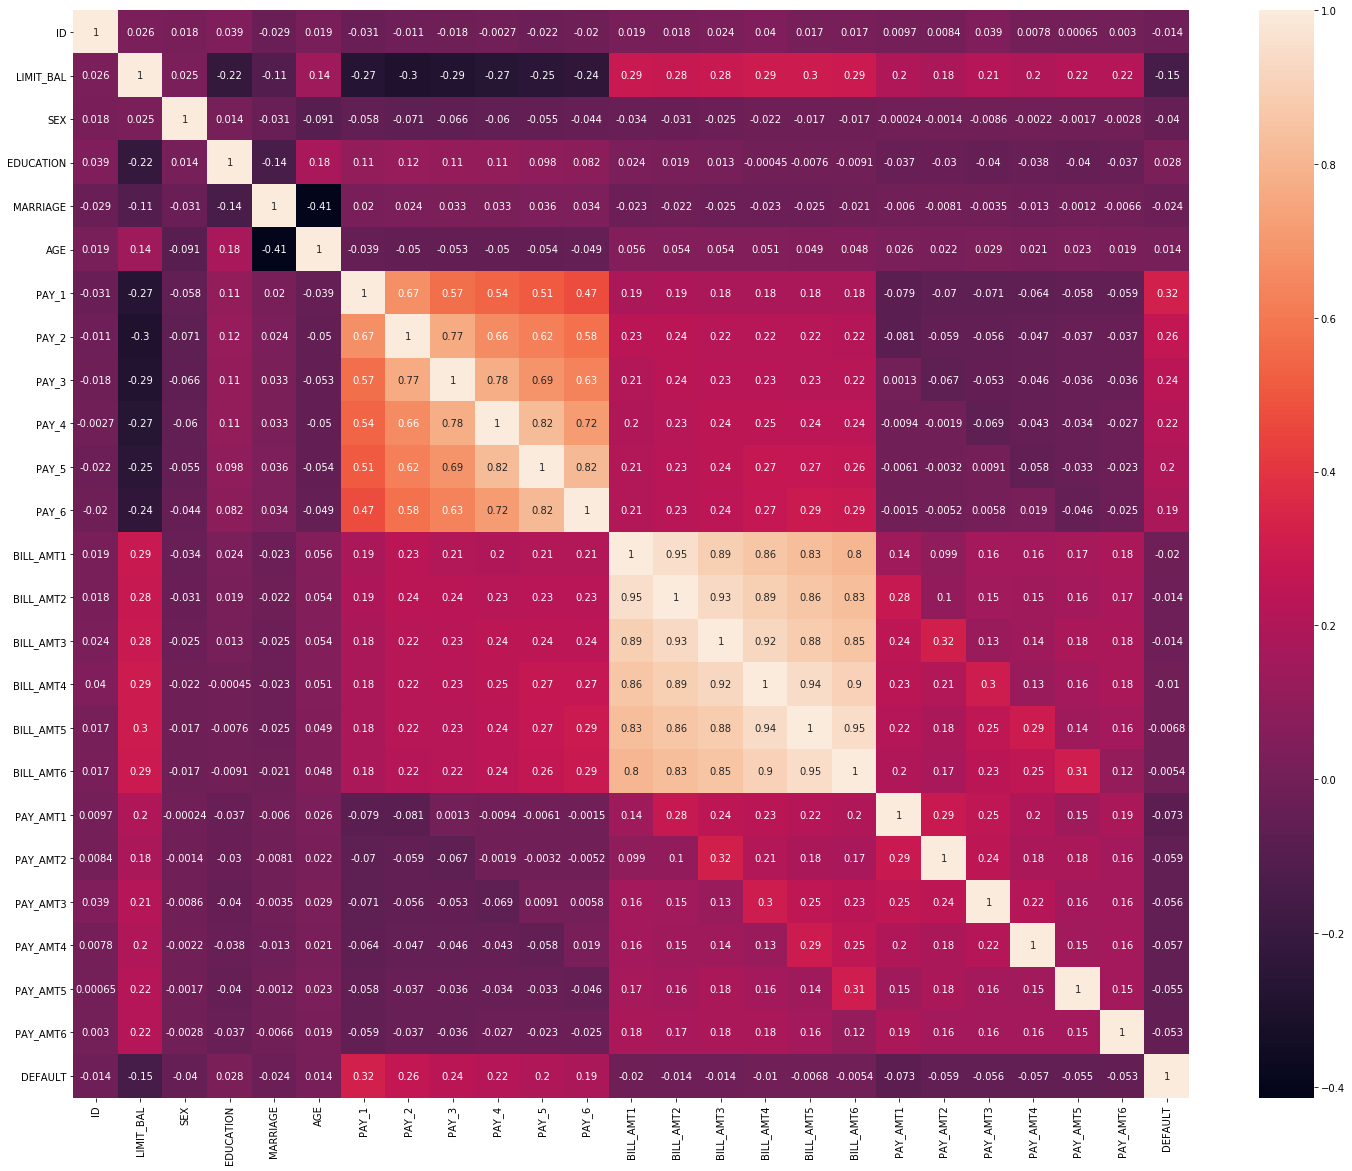

In [15]:
plt.figure(figsize=(25,20))
sns.heatmap(df.corr(),annot=True)
plt.show()

#### Pairplot:

In [ ]:
sns.pairplot(df)
plt.show()

## Feature Engineering:

#### Binning the 'AGE' column

In [16]:
def age(x):
    if x in range(21,41):
        return 1
    elif x in range(41,61):
        return 2
    elif x in range(61,80):
        return 3

df['AGE']=df['AGE'].apply(age)

#### Binning the 'PAY' column

In [17]:
def bins(x):
    if x == -2:
        return 'Paid Duly'
    if x == 0:
        return 'Paid Duly'
    if x == -1:
        return 'Paid Duly'
    if x in range(1,4):
        return '1 to 3'
    if x in range(4,7):
        return '4 to 6'
    if x in range(7,9):
        return '7 to 9'

for i in df[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]:
    df[i]=df[i].apply(bins)

#### Replacing 0,5,6 to 4 in education columns

In [18]:
def rep(x):
    if x in [0,4,5,6]:
        return 4
    else:
        return x
df['EDUCATION']=df.EDUCATION.apply(rep)

In [19]:
# Dataset after feature engineering

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,1,1 to 3,1 to 3,Paid Duly,Paid Duly,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,1,Paid Duly,1 to 3,Paid Duly,Paid Duly,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,1,Paid Duly,Paid Duly,Paid Duly,Paid Duly,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,1,Paid Duly,Paid Duly,Paid Duly,Paid Duly,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,2,Paid Duly,Paid Duly,Paid Duly,Paid Duly,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Encoding categorical variable:

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes(include=object).columns:
    df[col] = le.fit_transform(df[col])

## Splitting dataset in dependent and independent variable:

In [21]:
X =df.drop('DEFAULT',axis=1)
y = df['DEFAULT']

## Splitting dataset into train and test split:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Checking if Data is Imbalance:

0    77.88
1    22.12
Name: DEFAULT, dtype: float64


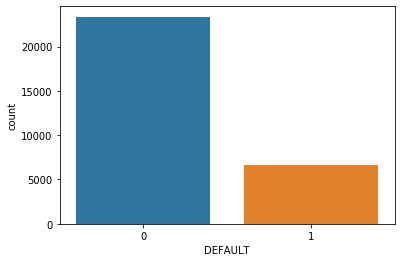

In [23]:
print((df['DEFAULT'].value_counts()/df['DEFAULT'].shape)*100)
sns.countplot(df['DEFAULT'])
plt.show()

Here we can see that the data is imbalanced.

#### Balancing the dataset:

In [24]:
print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape)) 
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

Before OverSampling, the shape of train_X: (21000, 24)
Before OverSampling, the shape of train_y: (21000,) 



In [25]:
smote = SMOTE(sampling_strategy='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

In [26]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_sm.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_sm.shape))

After OverSampling, the shape of train_X: (32728, 24)
After OverSampling, the shape of train_y: (32728,) 



## Modelling:

### Base Model using LogisticRegression:

In [27]:
logreg = LogisticRegression(solver='liblinear', fit_intercept=True)

logreg.fit(X_train_sm, y_train_sm)

y_prob_train = logreg.predict_proba(X_train_sm)[:,1]
y_pred_train = logreg.predict (X_train_sm)

print('Classification report - Train: ', '\n', classification_report(y_train_sm, y_pred_train))

y_prob = logreg.predict_proba(X_test)[:,1]
y_pred = logreg.predict (X_test)

print('Classification report - Test: ','\n', classification_report(y_test, y_pred))

Classification report - Train:  
               precision    recall  f1-score   support

           0       0.62      0.60      0.61     16364
           1       0.61      0.64      0.63     16364

    accuracy                           0.62     32728
   macro avg       0.62      0.62      0.62     32728
weighted avg       0.62      0.62      0.62     32728

Classification report - Test:  
               precision    recall  f1-score   support

           0       0.85      0.61      0.71      7000
           1       0.31      0.61      0.41      2000

    accuracy                           0.61      9000
   macro avg       0.58      0.61      0.56      9000
weighted avg       0.73      0.61      0.64      9000



### Feature selection- Backward Elimination:

In [28]:
Xc=sm.add_constant(X_train_sm)

model = sm.Logit ( y_train_sm , Xc ).fit ( )
model.summary ( )

Optimization terminated successfully.
         Current function value: 0.491395
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                32728
Model:                          Logit   Df Residuals:                    32703
Method:                           MLE   Df Model:                           24
Date:                Tue, 20 Oct 2020   Pseudo R-squ.:                  0.2911
Time:                        23:01:04   Log-Likelihood:                -16082.
converged:                       True   LL-Null:                       -22685.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5808      0.110     68.678      0.000       7.364       7.797
ID         -1.337e-06   1.65e-06     -0.811      0.417   -4.57e-06    1.89e-06
LIMIT_BAL  -1.616e-06   1.32e-07    -12.284      0.000   -1.87e-06   -1.36e-06
SEX           -0.7628      0.028    -27.585      0.000      -0.817      -0.709
EDUCATION     -0.4474      0.022    -20.666      0.000      -0.490      -0.405
MARRIAGE      -1.0975      0.029    -38.159      0.000      -1.154      -1.041
AGE           -0.8050      0.034    -23.377      0.000      -0.873      -0.738
PAY_1         -0.5265      0.013    -39.833      0.000      -0.552      -0.501
PAY_2         -0.1279      0.018     -7.047      0.000      -0.164      -0.092
PAY_3         -0.1826      0.018    -10.159      0.000      -0.218      -0.147
PAY_4         -0.1304      0.020     -6.461      0.000      -0.170      -0.091
PAY_5         -0.1029      0.023     -4.485      0.000      -0.148      -0.058
PAY_6         -0.1357      0.020     -6.817      0.000      -0.175      -0.097
BILL_AMT1  -1.368e-06   8.96e-07     -1.528      0.127   -3.12e-06    3.87e-07
BILL_AMT2   2.466e-06   1.24e-06      1.984      0.047    2.95e-08     4.9e-06
BILL_AMT3   2.589e-06   1.17e-06      2.212      0.027    2.95e-07    4.88e-06
BILL_AMT4  -1.267e-06   1.21e-06     -1.043      0.297   -3.65e-06    1.11e-06
BILL_AMT5  -1.321e-06   1.43e-06     -0.925      0.355   -4.12e-06    1.48e-06
BILL_AMT6   6.206e-07   1.11e-06      0.560      0.575   -1.55e-06    2.79e-06
PAY_AMT1   -1.444e-05   1.93e-06     -7.487      0.000   -1.82e-05   -1.07e-05
PAY_AMT2   -8.407e-06   1.61e-06     -5.226      0.000   -1.16e-05   -5.25e-06
PAY_AMT3   -1.098e-06   1.42e-06     -0.772      0.440   -3.88e-06    1.69e-06
PAY_AMT4   -5.891e-06   1.67e-06     -3.530      0.000   -9.16e-06   -2.62e-06
PAY_AMT5   -5.164e-06   1.57e-06     -3.287      0.001   -8.24e-06   -2.08e-06
PAY_AMT6   -4.493e-06   1.22e-06     -3.694      0.000   -6.88e-06   -2.11e-06
==============================================================================
"""

In [29]:
cols = list(X_train_sm.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train_sm[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train_sm,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print("Important features: {}".format(selected_features_BE))
print("\nNumber of important features: {}".format(len(selected_features_BE)))

Important features: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT2', 'BILL_AMT5', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

Number of important features: 18


In [30]:
# Adding target column

selected_features_BE.append('DEFAULT')
df2=df[selected_features_BE]

### Logistic Regression with important feature:

In [31]:
X = df2.drop('DEFAULT',axis=1)
y = df2['DEFAULT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

smote = SMOTE(sampling_strategy='minority')
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

logreg = LogisticRegression(solver='liblinear', fit_intercept=True)

logreg.fit(X_train, y_train)

y_prob_train = logreg.predict_proba(X_train)[:,1]
y_pred_train = logreg.predict (X_train)

print('Classification report - Train: ', '\n', classification_report(y_train, y_pred_train))

y_prob = logreg.predict_proba(X_test)[:,1]
y_pred = logreg.predict (X_test)

print('Classification report - Test: ','\n', classification_report(y_test, y_pred))

Classification report - Train:  
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     16364
           1       0.43      0.00      0.00      4636

    accuracy                           0.78     21000
   macro avg       0.60      0.50      0.44     21000
weighted avg       0.70      0.78      0.68     21000

Classification report - Test:  
               precision    recall  f1-score   support

           0       0.78      1.00      0.87      7000
           1       0.00      0.00      0.00      2000

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.60      0.78      0.68      9000



### Decission Tree:

In [32]:
# Defining an object for DTC and fitting for whole dataset
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=1 )
dt.fit(X_train_sm, y_train_sm)

y_pred_train = dt.predict(X_train_sm)
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)

In [33]:
#Classification for test before hyperparameter tuning
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      7000
           1       0.50      0.50      0.50      2000

    accuracy                           0.78      9000
   macro avg       0.68      0.68      0.68      9000
weighted avg       0.78      0.78      0.78      9000



#### Hyperparameter Tuning:

In [34]:
dt = DecisionTreeClassifier(random_state=1)

params = {'criterion': ['gini','entropy'],
          'splitter' : ["best", "random"],
          'max_depth' : [2,4,6,8,10,12],
          'min_samples_split': [2,3,4,5],
          'min_samples_leaf': [1,2,3,4,5]}

rand_search_dt = RandomizedSearchCV(dt, param_distributions=params, cv=3)

rand_search_dt.fit(X_train_sm,y_train_sm)

rand_search_dt.best_params_

{'splitter': 'best',
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 12,
 'criterion': 'entropy'}

In [35]:
# Passing best parameter for the Hyperparameter Tuning
dt = DecisionTreeClassifier(**rand_search_dt.best_params_, random_state=1)

dt.fit(X_train_sm, y_train_sm)

y_pred = dt.predict(X_test)

In [36]:
#Classification for test after hyperparameter tuning
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      7000
           1       0.43      0.46      0.44      2000

    accuracy                           0.75      9000
   macro avg       0.64      0.64      0.64      9000
weighted avg       0.75      0.75      0.75      9000



### Random Forest:

In [37]:
#Create a Gaussian Classifier
rfc=RandomForestClassifier(n_estimators=100, random_state=1)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(X_train_sm,y_train_sm)

y_pred = rfc.predict(X_test)

In [38]:
#Classification for test after hyperparameter tuning
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7000
           1       0.52      0.43      0.47      2000

    accuracy                           0.78      9000
   macro avg       0.68      0.66      0.67      9000
weighted avg       0.77      0.78      0.78      9000



#### Hyperparameter Tuning:

In [39]:
rfc = RandomForestClassifier(random_state=1)

params = {'n_estimators': sp_randint(5,30),
          'criterion' : ['gini','entropy'],
          'max_depth' : sp_randint(2,10),
          'min_samples_split' : sp_randint(2,20),
          'min_samples_leaf' : sp_randint(1,20),
          'max_features' : sp_randint(2,18)}

rand_search_rfc = RandomizedSearchCV(rfc, param_distributions=params, random_state=1, cv=3)

rand_search_rfc.fit(X_train_sm,y_train_sm)

rand_search_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 9,
 'min_samples_leaf': 10,
 'min_samples_split': 19,
 'n_estimators': 28}

In [40]:
# Passing best parameter for the Hyperparameter Tuning
rfc = RandomForestClassifier(**rand_search_rfc.best_params_, random_state=1)

rfc.fit(X_train_sm, y_train_sm)

y_pred = rfc.predict(X_test)

In [41]:
#Classification for test after hyperparameter tuning
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      7000
           1       0.50      0.49      0.50      2000

    accuracy                           0.78      9000
   macro avg       0.68      0.68      0.68      9000
weighted avg       0.78      0.78      0.78      9000

